In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]
time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h'].dt.total_seconds() / 3600.0


In [3]:
import pandas as pd

# Assuming df is your DataFrame
columns_to_check = [f'SA_region_{i}' for i in range(18)] + [f'length_density_region_{i}' for i in range(18)]

# Filter DataFrame rows where any of the specified columns have NaN values
df_filtered = time_plate_info[time_plate_info[columns_to_check].isna().any(axis=1)]

# Find the unique ids corresponding to those rows
unique_ids_with_nans = df_filtered['unique_id'].unique()

print("Unique IDs with at least one NaN in specified columns:", unique_ids_with_nans)


Unique IDs with at least one NaN in specified columns: []


In [4]:
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [5]:
# Read the Excel file
path = r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\Corentin Bisot\PC\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)

df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day'] = pd.to_datetime(df['day'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['lost weight'] = df['lost weight'].fillna(0)
df['wet weight'] = df['wet weight']- df['lost weight']



grouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['wet weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
mean0P = np.median(df[df['type']=='agar0P']['C_P'])

df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6

df = df[df['type'] == 'agar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)


In [6]:
time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()
def get_integrated_density(row):
    unique_id = row['unique_id']
    pos = row['pos']
    arrangement = row['arrangement']
    if arrangement == 'basic':
        col_names = [f'integrated_SA_{pos-1}']
    if arrangement == 'simple':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in simple_to_basic_mapping[pos]]
    if arrangement == 'coarse':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in coarse_to_basic_mapping[pos]]    
    if not unique_id is np.nan:
        last_value_row = last_values[last_values['unique_id'] == int(unique_id)]
        return np.sum(last_value_row[col_names].values) if not last_value_row.empty else None
    else:
        return(None)
# Apply the function to fill the 'integrated_density' column
df['integrated_SA'] = df.apply(get_integrated_density, axis=1)

In [7]:
df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['wet weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
grouped['integrated_SA_C']=grouped['integrated_SA']/grouped['wet weight']


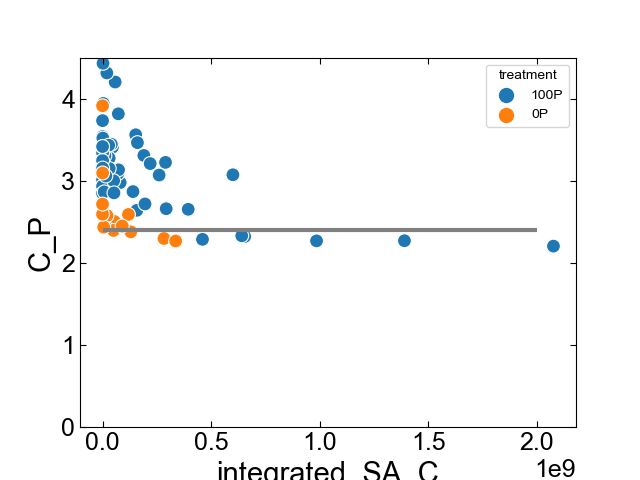

In [8]:
fig,ax = plt.subplots()
df = df[df['plate']!=431]
sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment")
# ax.set_xscale('log')
ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(0,4.5)
plt.show()

2023-10-02 18:49:14,882-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


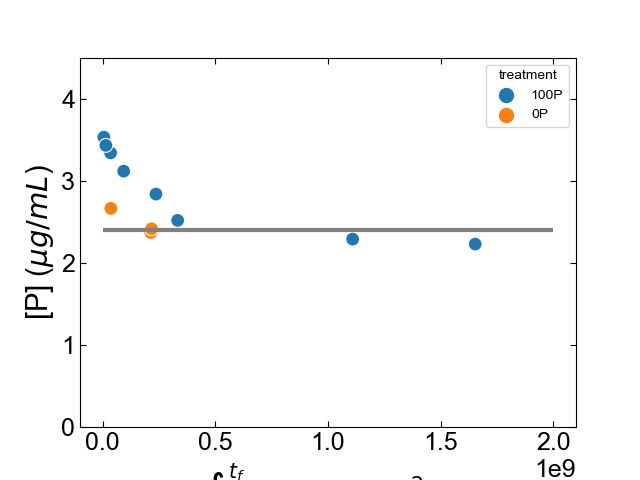

In [9]:
fig,ax = plt.subplots()
grouped = grouped[grouped['plate']!=431]
# sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment",s = 6)
sns.scatterplot(grouped,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment")
# ax.set_xscale('log')
ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(0,4.5)
plt.ylabel('[P] ($\mu g/mL$)')
plt.xlabel('$\int_0^{t_f} SA(t)dt$ ($\mu m^2h$)')
plt.savefig(os.path.join('figures', 'P_SA.pdf'), transparent=True, bbox_inches='tight')

plt.show()

In [10]:
# import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# Define the Michaelis-Menten differential equation
def mm_eq(S, t, A_t, Vmax, Km):
    return -Vmax * (A_t * S / (Km + S))

# Objective function to minimize
def objective(params, all_times, all_areas, all_final_concentrations, initial_concentration):
    Vmax, Km = params
    total_error = 0

    # Loop over each unique time series
    for times, areas, final_S in zip(all_times, all_areas, all_final_concentrations):
        S = initial_concentration
        # Integrate for each time step within this series
        last_time = 0  # Keep track of the last time point

        # Integrate for each time step within this series
        for t, a in zip(times, areas):
            S = odeint(mm_eq, S, [last_time, t], args=(a, Vmax, Km))[-1]
            last_time = t  # Update the last time point for the next iteration
        # Sum of squared error for this series
        if not np.isnan(S[0]):
            total_error += (S[0] - final_S)**2
        # if np.isnan(total_error):
        #     print(total_error,times,areas)
        #     break
    print(total_error)
    return total_error


In [11]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Sorting the DataFrame just in case
time_plate_info = time_plate_info.sort_values(['unique_id', 'time_since_begin_hour'])

all_times = []
all_areas = []
all_final_concentrations=[]
unique_ids = time_plate_info['unique_id'].unique()

# Loop over each unique_id
for unique_id in unique_ids:
    select_df = df[df['unique_id'].astype(np.int64)==unique_id]
    subset_df = time_plate_info[time_plate_info['unique_id'] == unique_id]
    time_series = subset_df['time_since_begin_hour'].values
    for index,row in select_df.iterrows():
        arrangement = row['arrangement']
        index = row['pos']
        vol = row['wet weight']
        P_C = row['C_P']
        treatment = row['treatment']
        indexes = get_regions(arrangement, index)
        area_series = [subset_df[f'SA_region_{i}'].values for i in indexes]
        
        # Append the time and area series to the lists
        if P_C<5 and treatment!='0P':
            all_times.append(time_series)
            all_areas.append(np.sum(area_series,axis=0)/vol)
            all_final_concentrations.append(max(P_C-mean0P,0))
# Now, all_times and all_areas contain the time and area series for each unique_id and each region
initial_concentration = 3.5-mean0P

***whole plate***

In [12]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Sorting the DataFrame just in case
time_plate_info = time_plate_info.sort_values(['unique_id', 'time_since_begin_hour'])

all_times = []
all_areas = []
all_final_concentrations=[]
unique_ids = time_plate_info['unique_id'].unique()

# Loop over each unique_id
for unique_id in unique_ids:
    select_df = df[df['unique_id'].astype(np.int64)==unique_id]
    subset_df = time_plate_info[time_plate_info['unique_id'] == unique_id]
    time_series = subset_df['time_since_begin_hour'].values
    area_series = [subset_df[f'SA_region_{i}'].values for i in range(18)]        # Append the time and area series to the lists
    vol = np.sum(select_df['wet weight'])
    P_C = np.sum(select_df['totP (ug)'])/vol
    treatment = select_df['treatment'].iloc[0]
    if P_C<5 and treatment!='0P':
        all_times.append(time_series)
        all_areas.append(np.sum(area_series,axis=0)/vol)
        print(vol)
        all_final_concentrations.append(max(P_C-mean0P,0))
# Now, all_times and all_areas contain the time and area series for each unique_id and each region
initial_concentration = 3.5-mean0P

24.3853
24.552
24.878800000000002
25.6828
24.993199999999998
25.7934
23.744699999999998
25.4568


In [13]:
length_used = 20
all_times_extra = []
all_areas_extra = []
for times, areas in zip(all_times, all_areas):
    # Fit the last 4 points
    z = np.polyfit(times[:length_used], areas[:length_used], 1)
    p = np.poly1d(z)

    # Predicted values
    zero_time = -z[1] / z[0]+2
    if zero_time<0:
        extrapolated_time = np.linspace(zero_time, times[0], 10)
        predicted_area = p(extrapolated_time)
    else:
        extrapolated_time = []
        predicted_area = []
    all_times_extra.append(list(extrapolated_time)+list(times))
    all_areas_extra.append(list(predicted_area)+list(areas))
all_times, all_areas = all_times_extra, all_areas_extra

In [14]:
initial_guesses = [1e-8,1]
initial_concentration = 3.5-mean0P
deltas = np.array([1e-7, 10])
init_params = initial_guesses
simplex = [init_params]
for i in range(len(init_params)):
    new_point = np.copy(init_params)
    new_point[i] += deltas[i]
    simplex.append(new_point)

# Convert to numpy array for use in scipy.minimize
initial_simplex = np.array(simplex)
result = minimize(objective, initial_guesses, args=(all_times, all_areas, all_final_concentrations, initial_concentration), method='Nelder-Mead', options={'initial_simplex': initial_simplex,"xatol" : 0.1})
Vmax, Km = result.x

# Print results
print(f"Best-fitting parameters: Vmax = {Vmax}, Km = {Km}")

0.10826259792380219
2.249860367290869
1.0339116266870323
13641.215417396812
0.7489014798651155


C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


196.71187141894447
0.07505533328939948
1500.9291741021273
0.3429477368165768
35.712325130109434
0.12680346773248038
0.7275456829407861
0.0491250428756793
0.05177925842283894
0.042758050370057615
0.07889720459765255
0.6952364700640351
0.03507112197822388
0.03508258838160779
0.04687379354924668
0.0349729552232354
0.03317828644422586
0.04012065377478865
0.04484857144741524
0.03365333347658317
0.03213391311014303
0.04261994038926683
0.027996966080798893
0.23718210534752054
0.04014291810811915
0.03154228234076693
0.03622353119731401
0.030733391513781995
0.025608583456904747
0.019237984385011425
26.64468306945788
0.028340028451022597
0.01024387110157649
26.64468306945788
0.1161774660588969
0.023039783505895337
1.7122466817835238
0.018821653460736196
0.022191545916819915
0.015350781995204388
0.04423446800168244
0.015791228136728425
0.006382453851187307
0.04423446800168244
0.1618921065477704
0.01130236233182983
0.023030454346183914
0.0093377750519707
0.008132988775134914
0.0049655061057810946


In [20]:
all_final_concentrations

[0.7207180897177072,
 0.9433725770269188,
 1.1344190838759611,
 0,
 1.035040335152079,
 0,
 0.4417044769063949,
 0.1215290162065914]

In [16]:
print(f"Best-fitting parameters: Vmax = {Vmax}, Km = {Km}")

Best-fitting parameters: Vmax = 2.785347385506596e-09, Km = 0.0019518127519404516


2023-10-02 19:03:33,823-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


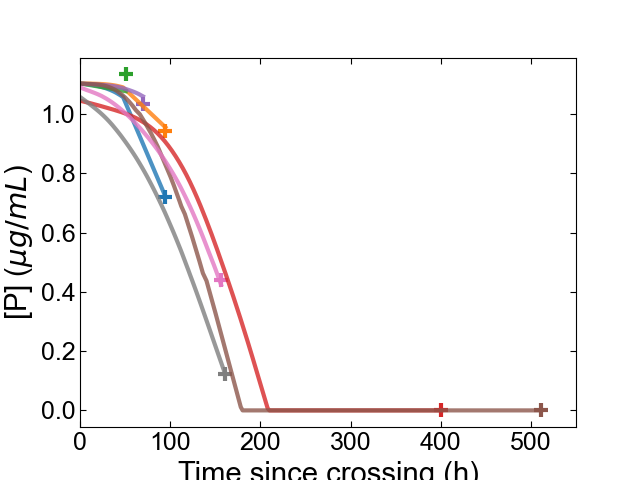

In [18]:
def get_predicted_concentration(times, areas, Vmax, Km, initial_concentration):
    S = initial_concentration
    last_time = 0  # Initialize the last time point
    S_values = []  # To store concentration at each time point
    
    # Integrate for each time step
    for t, a in zip(times, areas):
        S = odeint(mm_eq, S, [last_time, t], args=(a, Vmax, Km))[-1]
        S_values.append(S[0])  # Storing concentration at each time step
        last_time = t  # Update the last time point for next iteration
    
    return np.array(S_values)
plt.figure()

# Assuming you have a single time series for demonstration (replace with your actual time series)
i=0
for times, areas in zip(all_times, all_areas):
    predicted_S_values = get_predicted_concentration(times, areas, Vmax, Km, initial_concentration)
    concentration = all_final_concentrations[i]
    plt.plot(times, predicted_S_values, alpha = 0.8)
    plt.scatter(times[-1],actual_final_concentrations[i],marker = "+")
    i+=1
    
# Plotting predicted trajectory

plt.xlabel('Time since crossing (h)')
plt.ylabel('[P] ($\mu g/mL$)')
plt.xlim(0,550)
plt.savefig(os.path.join('figures', 'Time_concentration.pdf'), transparent=True, bbox_inches='tight')


NameError: name 'get_predicted_concentration' is not defined

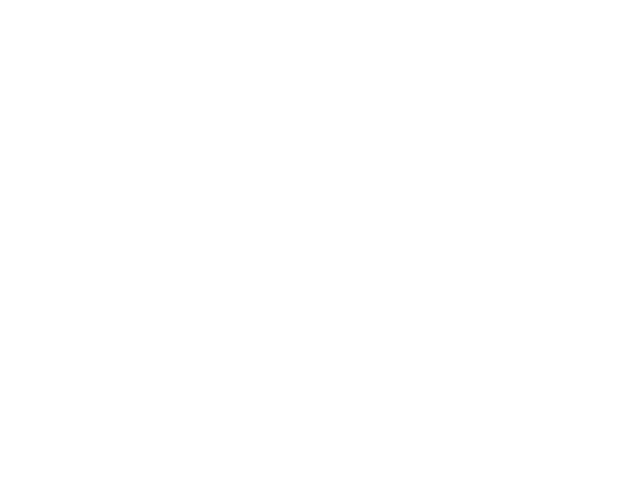

In [17]:
predicted_final_concentrations = []
actual_final_concentrations = all_final_concentrations  # Assuming this is already available
Vmax, Km = result.x
plt.figure()

# Calculate predicted final concentrations
for times, areas, final_C in zip(all_times, all_areas,all_final_concentrations):
    predicted_S = get_predicted_concentration(times, areas, Vmax, Km, initial_concentration)
    predicted_final_concentrations.append(predicted_S[-1])
    plt.scatter(final_C,predicted_S[-1],marker = "+")

# Create the plot
# plt.scatter(actual_final_concentrations, predicted_final_concentrations, c='blue')
plt.xlabel('Actual [P]')
plt.ylabel('Predicted [P]')

# Plot a 45-degree line for reference
min_val = min(min(actual_final_concentrations), min(predicted_final_concentrations))
max_val = max(max(actual_final_concentrations), max(predicted_final_concentrations))
print(objective([Vmax, Km],all_times,all_areas,all_final_concentrations,initial_concentration))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.savefig(os.path.join('figures', 'modelfit.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
# Assuming you have a single time series for demonstration (replace with your actual time series)
plt.figure()

i=0
for times, areas in zip(all_times, all_areas):
    plt.plot(times, areas*25, label=unique_ids[i])
    # plt.scatter(times[-1],actual_final_concentrations[i])
    i+=1
    
# Plotting predicted trajectory

plt.xlabel('Time since crossing (h)')
plt.ylabel('Surface Area ($\mu m^2$)')
# plt.legend()
plt.yscale('log')
# plt.xscale('log')

plt.xlim(-10,500)
plt.savefig(os.path.join('figures', 'time_SA.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
def get_regions(arrangement, index):
    coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

    # Mapping for "simple" to "basic"
    simple_to_basic_mapping = {
        0: list(range(1, 11)),
        1: list(range(11, 19))
    }
    if arrangement == 'basic':
        indexes = [index-1]
    if arrangement == 'simple':
        indexes = [basic_pos-1 for basic_pos in simple_to_basic_mapping[index]]
    if arrangement == 'coarse':
        indexes = [basic_pos-1 for basic_pos in coarse_to_basic_mapping[index]] 
    return(indexes)

In [ ]:
fig,ax = plt.subplots()
for index,time in enumerate(all_times):
    ax.plot(time,all_areas[index])
# all_areas

In [ ]:
from PIL import Image
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)
df['C_P'] = df['totP (ug)']/df['wet weight'] 
basic_mapping = {
    1: (0, 0), 2: (0, 1), 3: (0, 2), 4: (0, 3), 5: (0, 4),
    6: (1, 0), 7: (1, 1), 8: (1, 2), 9: (1, 3), 10: (1, 4),
    11: (2, 0), 12: (2, 1), 13: (2, 2), 14: (2, 3), 15: (2, 4),
    16: (3, 1), 17: (3, 2), 18: (3, 3)
}

# Mapping for "coarse" to "basic"
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}

# Initialize plot
plt.close("all")
for idx, unique_id in enumerate(df['unique_id'].unique()):
    if type(unique_id) ==str:
        fig,ax = plt.subplots()
        plate_df = df[df['unique_id'] == unique_id]

        # Create an empty 4x5 grid (for "basic" arrangement, adjust as needed)
        grid = np.zeros((4, 5))

        for i, row in plate_df.iterrows():
            arrangement = row['arrangement']
            pos = row['pos']
            totP = row['integrated_SA']
            totP = row['C_P']
            

            if arrangement == 'basic':
                x, y = basic_mapping[pos]
                grid[x, y] = totP

            elif arrangement == 'simple':
                for basic_pos in simple_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

            elif arrangement == 'coarse':
                for basic_pos in coarse_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

        # Plotting the grid
        image_path = os.path.join("C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\DATA\\PRINCE_ANALYSIS", unique_id)

        # Find the image in the folder with name like 'StitchedImage_YYYYMMDD_hhmm.tif'
        for image_file in os.listdir(image_path):
            if 'StitchedImage' in image_file:
                img = Image.open(os.path.join(image_path, image_file))

        # Display the image
        ax.imshow(np.array(img), cmap='gray', extent=[-0.5, 4.5, -0.5, 3.5])
        c = ax.imshow(grid, cmap='Reds', aspect='auto',alpha = 0.5)
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label('P contration (ug/mL)', rotation=270, labelpad=20)
        ax.set_title(f'Plate {unique_id}')
        ax.set_xticks([])
        ax.set_yticks([])
        
    # break
# plt.show()